In [1]:
import numpy as np
import pandas as pd 
import re
import unicodedata
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option("max_columns", 20)
pd.set_option("max_rows", 20)

In [2]:
import pandas as pd

df = pd.read_csv('recipes_final.csv')
df.drop_duplicates(inplace = True)
df.dropna(subset=['Ingredients'], inplace=True)
df = df.reset_index(drop=True)
df['RecipeId'] = np.arange(1, df.shape[0] + 1)
df = df[['RecipeId', 'Recipe', 'Url', 'Ingredients', 'Ratings', 'Serving', 'Prepration_Time',
       'Calories', 'Protein', 'Carbohydrate', 'Fat']]
df

,RecipeId,Recipe,Url,Ingredients,Ratings,Serving,Prepration_Time,Calories,Protein,Carbohydrate,Fat
0,1,Broccoli and Cheese Galette Recipe,https://www.seriouseats.com/savory-broccoli-an...,"1/2 batch Old-Fashioned Flaky Pie Dough,5 tabl...",0,8,2 hrs 30 mins,471,12,35,32
1,2,Simple Pear Galette With Vanilla Recipe,https://www.seriouseats.com/pear-galette-recipe,"1/2 batch Old-Fashioned Flaky Pie Dough,1 vani...",0,8,3 hrs,346,4,47,15
2,3,Freeform Peach Pie (Galette) Recipe,https://www.seriouseats.com/freeform-peach-pie...,"1/2 batch Old-Fashioned Flaky Pie Dough,4 larg...",14,8,3 hrs,350,5,49,15
3,4,"Flaky, Tender, and Nutty Whole Wheat Pie Crust...",https://www.seriouseats.com/whole-wheat-pie-cr...,4 ounces all-purpose flour (about 1 cup minus ...,0,20,2 hrs 30 mins,104,1,9,7
4,5,Easy Pie Dough Recipe,https://www.seriouseats.com/easy-pie-dough-recipe,2 1/2 cups (12.5 ounces; 350g) all-purpose flo...,70,16,2 hrs 20 mins,211,2,18,14
...,...,...,...,...,...,...,...,...,...,...,...
2079,2080,Quick Pickled Sugarsnap Peas Recipe,https://www.seriouseats.com/quick-pickled-suga...,"12 ounces sugar snap peas (4- to 5-cups),1 1/4...",0,12,24 hrs,23,1,4,0
2080,2081,Basic Salsa Verde (Mexican Tomatillo Salsa) Re...,https://www.seriouseats.com/basic-salsa-verde-...,"1 1/2 pounds tomatillos, husks and stems remov...",0,20,15 mins,15,1,3,0
2081,2082,Pickled Oyster Mushrooms Recipe,https://www.seriouseats.com/pickled-oyster-mus...,"1 pound oyster mushrooms,2 1/2 cups rice vineg...",0,16,48 hrs,23,1,3,0
2082,2083,Sweet Pickled Daikon Radish Recipe,https://www.seriouseats.com/sweet-pickled-daik...,"1 pound daikon radish,1 1/2 cups rice wine vin...",0,16,48 hrs,33,0,7,0


In [3]:
df_GHG = pd.read_csv(r'Food_Production.csv')
df_GHG.loc[:, :'Total_emissions']

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions
0,Wheat,0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4
1,Maize,0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1
2,Barley,0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0
...,...,...,...,...,...,...,...,...,...
39,Eggs,0.7,2.2,1.3,0.0,0.1,0.2,0.0,4.5
40,Fish,0.5,0.8,3.6,0.0,0.1,0.1,0.0,5.1
41,Shrimps,0.2,2.5,8.4,0.0,0.2,0.3,0.2,11.8
42,Bread,0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4


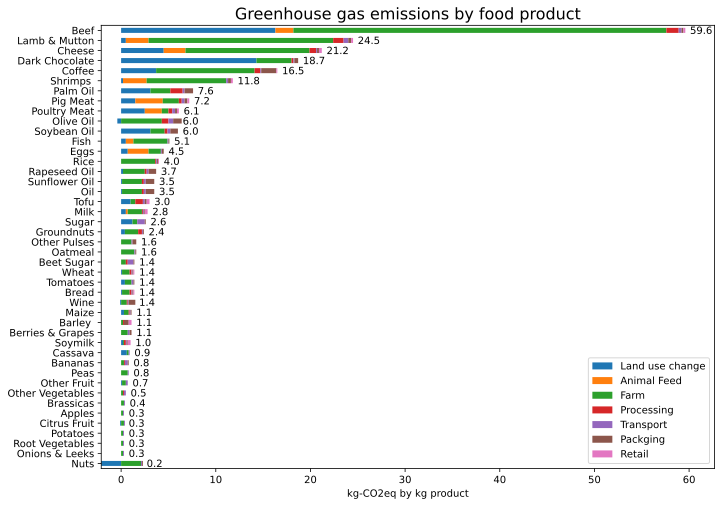

In [4]:
%config InlineBackend.figure_format = 'svg'
srtid = df_GHG['Total_emissions'].sort_values().index
plt.rcdefaults()
ax = df_GHG.loc[srtid, 'Land use change':'Retail'].plot(kind='barh', stacked=True, figsize=(11,8))
ax.set_yticklabels(df_GHG['Food product'][srtid])
ax.set_xlabel('kg-CO2eq by kg product')
ax.set_title('Greenhouse gas emissions by food product', fontsize=16)
for i, v in enumerate(df_GHG['Total_emissions'][srtid]):
    if i == 0:
        ax.text(v + 2.5, i - 0.35, str(v))
    else:
        ax.text(v + 0.5, i - 0.35, str(v))
plt.show()

In [5]:
# sum(results['ghg'] < em)*100 / N

l = ['chicken','wings','meat','salmon','salmons','cob','cobs','kebab','kebabs','fish','snake','gosht','bacon','mutton','lamb','egg','eggs']
nv = ['chicken','meat']
vg_nv = []
for name,cat in zip(df.Recipe,df.Ingredients):
    n = str(name).split()
    f=0
    if cat in nv:
        vg_nv.append('0')
    else: 
        for i in n:
            if i.lower() in l:
                f=1
        if f==1:
            vg_nv.append('0')
        else:
            vg_nv.append('1')
df['Veg_Non'] = vg_nv
df.head()

,RecipeId,Recipe,Url,Ingredients,Ratings,Serving,Prepration_Time,Calories,Protein,Carbohydrate,Fat,Veg_Non
0,1,Broccoli and Cheese Galette Recipe,https://www.seriouseats.com/savory-broccoli-an...,"1/2 batch Old-Fashioned Flaky Pie Dough,5 tabl...",0,8,2 hrs 30 mins,471,12,35,32,1
1,2,Simple Pear Galette With Vanilla Recipe,https://www.seriouseats.com/pear-galette-recipe,"1/2 batch Old-Fashioned Flaky Pie Dough,1 vani...",0,8,3 hrs,346,4,47,15,1
2,3,Freeform Peach Pie (Galette) Recipe,https://www.seriouseats.com/freeform-peach-pie...,"1/2 batch Old-Fashioned Flaky Pie Dough,4 larg...",14,8,3 hrs,350,5,49,15,1
3,4,"Flaky, Tender, and Nutty Whole Wheat Pie Crust...",https://www.seriouseats.com/whole-wheat-pie-cr...,4 ounces all-purpose flour (about 1 cup minus ...,0,20,2 hrs 30 mins,104,1,9,7,1
4,5,Easy Pie Dough Recipe,https://www.seriouseats.com/easy-pie-dough-recipe,2 1/2 cups (12.5 ounces; 350g) all-purpose flo...,70,16,2 hrs 20 mins,211,2,18,14,1


1    1805
0     279
Name: Veg_Non, dtype: int64


<AxesSubplot:xlabel='Veg_Non', ylabel='count'>

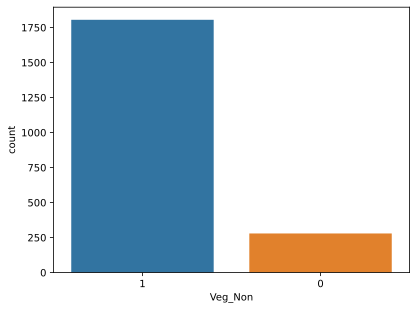

In [6]:
print(df.Veg_Non.value_counts())
sns.countplot(df.Veg_Non)
# plt.savefig('vegnon.png')

In [7]:
def standardize_units(text):

    units = {"cup": ["cups", "c.", "c"], 
             "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounces"],
             "gallon": ["gal", "gal.", "gallons"], 
             "ounce": ["oz", "oz.", "ounces"],
             "pint": ["pt", "pt.", "pints"], 
             "pound": ["lb", "lb.", "pounds"],
             "quart": ["qt", "qt.", "qts", "qts.", "quarts"],
             "tablespoon": ["tbsp.", "tbsp", "tablespoons", "tbs.", "tbs"],
             "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoons"],
             "gram": ["g", "g.", "gr", "gr.", "grams"], 
             "kilogram": ["kg", "kg.", "kilograms"],
             "liter": ["liter", "liters"], 
             "milligram": ["mg", "mg.", "milligrams"],
             "milliliter": ["ml", "ml.", "milliliters"], 
             "pinch": ["pinches"],
             "dash": ["dashes"], 
             "touch": ["touches"], 
             "handful": ["handfuls"],
             "stick": ["sticks"], 
             "clove": ["cloves"], 
             "can": ["cans"], 
             "scoop": ["scoops"], 
             "filets": ["filets"], 
             "sprig": ["sprigs"],
             "slice": ["slices"],
             "stalk": ["stalks"],
             "piece": ["pieces"]}

    for key in list(units.keys()):
        for syn in units[key]:
            if ' '+syn+' ' in text:
                text = text.replace(syn, key)
    return text


In [8]:
ghg_values = []
for irec, lines in enumerate(df['Ingredients']):
    cleans = re.sub('[!;*)@#%(&$_?.^]', '', lines)
    lines = standardize_units(cleans)
    lst_ghg_val = df_GHG['Food product'].values
    ingr_in_emission = {'Ingredients': [], 'ghg': []}
    GHG_total = 0
    for seq in lines.split(','):
        if any(map(str.isdigit, seq)):
            for indx, product in enumerate(lst_ghg_val):
                if product.lower() in seq:
                    ghg = df_GHG['Total_emissions'][indx]
                    if seq not in ingr_in_emission['Ingredients']:
                        ingr_in_emission['Ingredients'].append(unicodedata.normalize('NFKC', seq))
                        ingr_in_emission['ghg'].append(ghg)
                        
        else:
            for indx, product in enumerate(lst_ghg_val):
                if product.lower() in seq:
                     if seq not in ingr_in_emission['Ingredients']:
                        ingr_in_emission['Ingredients'].append(unicodedata.normalize('NFKC', seq))
                        ingr_in_emission['ghg'].append(df_GHG['Total_emissions'][indx])

    if len(list(dict.fromkeys(ingr_in_emission['Ingredients']))) >= 2:
        total_val = 0
        for idex, val in enumerate(ingr_in_emission['Ingredients']):
            gt_val = 0
            for val in val.split(' '):
                if val[:1].isdigit() and val[-1] == 'g' or val[:1].isdigit() and val[-2:] == 'ml':
                    try:
                        gt_val += int(re.sub("[mlgk]","",val))
                    except:
                        pass
            if val[:1].isdigit() and val[-1] == 'g' or val[:1].isdigit() and val[-2:] == 'ml': pass
            else:
                # https://www.egginfo.co.uk/egg-facts-and-figures/industry-information/egg-sizes
                if 'eggs' in seq and 'large' in seq:
                    gt_val += 63 * int(re.findall(r'\d+', seq)[0])    
            
            if gt_val != 0:
                total_val += gt_val * ingr_in_emission['ghg'][idex]
            else:
                try:
                    if 'eggs' in ingr_in_emission['Ingredients'][idex] and 'large' in ingr_in_emission['Ingredients'][idex]:
                        total_val += 63 * int(re.findall(r'\d+', ingr_in_emission['Ingredients'][idex])[0]) * ingr_in_emission['ghg'][idex]
                    else:
                        total_val += int(re.findall(r'\d+', ingr_in_emission['Ingredients'][idex])[0]) * ingr_in_emission['ghg'][idex]
                except:
                    total_val += 0.001 * ingr_in_emission['ghg'][idex]
 
        ghg_values.append(total_val)
    
            
    else:
        df = df.drop(irec)
    
df['GHG_Emission'] = ghg_values
df = df.reset_index(drop=True)
emission_quantile = [round(sum(df['GHG_Emission'] < em)*100 / df.shape[0])
                     for em in df['GHG_Emission']]
df['Perc_Sustainability']= [100 - eq for eq in emission_quantile]
df                

,RecipeId,Recipe,Url,Ingredients,Ratings,Serving,Prepration_Time,Calories,Protein,Carbohydrate,Fat,Veg_Non,GHG_Emission,Perc_Sustainability
0,1,Broccoli and Cheese Galette Recipe,https://www.seriouseats.com/savory-broccoli-an...,"1/2 batch Old-Fashioned Flaky Pie Dough,5 tabl...",0,8,2 hrs 30 mins,471,12,35,32,1,4712.0,6
1,4,"Flaky, Tender, and Nutty Whole Wheat Pie Crust...",https://www.seriouseats.com/whole-wheat-pie-cr...,4 ounces all-purpose flour (about 1 cup minus ...,0,20,2 hrs 30 mins,104,1,9,7,1,200.0,54
2,6,The Ultimate Beef Wellington Recipe,https://www.seriouseats.com/the-ultimate-beef-...,"1 center-cut beef tenderloin, trimmed of silve...",16,8,3 hrs 40 mins,1029,34,48,75,1,66.6,63
3,8,Curried Jamaican Beef Patties Recipe,https://www.seriouseats.com/curried-jamaican-b...,"3 cups all-purpose flour,1/2 teaspoon kosher s...",7,6,2 hrs,822,32,62,49,1,126.6,58
4,9,"Spring Strata With Asparagus, Leeks, Sausage, ...",https://www.seriouseats.com/strata-asparagus-m...,"1 pound white bread, cut into 1 1/2-inch cubes...",0,8,2 hrs 30 mins,693,37,41,43,1,4948.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2076,The Best French Bread Pizza Recipe,https://www.seriouseats.com/the-best-french-br...,"3 tablespoons (45g) unsalted butter,4 tablespo...",13,4,40 mins,779,29,69,44,1,1551.4,21
1468,2078,Marinated Artichoke Hearts Recipe,https://www.seriouseats.com/marinated-artichok...,12 ounces trimmed artichoke hearts (8 to 10 sm...,0,5,24 hrs,90,2,9,6,1,13.4,84
1469,2080,Quick Pickled Sugarsnap Peas Recipe,https://www.seriouseats.com/quick-pickled-suga...,"12 ounces sugar snap peas (4- to 5-cups),1 1/4...",0,12,24 hrs,23,1,4,0,1,35.2,69
1470,2082,Pickled Oyster Mushrooms Recipe,https://www.seriouseats.com/pickled-oyster-mus...,"1 pound oyster mushrooms,2 1/2 cups rice vineg...",0,16,48 hrs,23,1,3,0,1,10.6,88


In [9]:
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 RecipeId               0
Recipe                 0
Url                    0
Ingredients            0
Ratings                0
Serving                0
Prepration_Time        0
Calories               0
Protein                0
Carbohydrate           0
Fat                    0
Veg_Non                0
GHG_Emission           0
Perc_Sustainability    0
dtype: int64


In [ ]:
cutoff1 = sorted(df['GHG_Emission'])[1000]
cutoff2 = sorted(df['GHG_Emission'])[1500]
print('First cutoff:', cutoff1, 'kg CO2 equivalent')
print('Second cutoff:', cutoff2, 'kg CO2 equivalent')

GHG_group = np.zeros(df.shape[0])
GHG_group[df['GHG_Emission'].between(cutoff1,cutoff2)] = 1
GHG_group[df['GHG_Emission'].between(cutoff2,df['GHG_Emission'].max())] = 2
# plt.plot(GHG_group[::100])
df['Group'] = GHG_group 
df

In [10]:
# create group vector (0 = low, 1 = medium, 2 = high)
GHG_group = np.zeros(df.shape[0])
GHG_group[df['GHG_Emission'].between(19.001,39)] = 1
GHG_group[df['GHG_Emission'].between(39.001,df['GHG_Emission'].max())] = 2
# plt.plot(GHG_group[::100])
df['Group'] = GHG_group 
df['Group'] = df['Group'].astype('Int64')
df

,RecipeId,Recipe,Url,Ingredients,Ratings,Serving,Prepration_Time,Calories,Protein,Carbohydrate,Fat,Veg_Non,GHG_Emission,Perc_Sustainability,Group
0,1,Broccoli and Cheese Galette Recipe,https://www.seriouseats.com/savory-broccoli-an...,"1/2 batch Old-Fashioned Flaky Pie Dough,5 tabl...",0,8,2 hrs 30 mins,471,12,35,32,1,4712.0,6,2
1,4,"Flaky, Tender, and Nutty Whole Wheat Pie Crust...",https://www.seriouseats.com/whole-wheat-pie-cr...,4 ounces all-purpose flour (about 1 cup minus ...,0,20,2 hrs 30 mins,104,1,9,7,1,200.0,54,2
2,6,The Ultimate Beef Wellington Recipe,https://www.seriouseats.com/the-ultimate-beef-...,"1 center-cut beef tenderloin, trimmed of silve...",16,8,3 hrs 40 mins,1029,34,48,75,1,66.6,63,2
3,8,Curried Jamaican Beef Patties Recipe,https://www.seriouseats.com/curried-jamaican-b...,"3 cups all-purpose flour,1/2 teaspoon kosher s...",7,6,2 hrs,822,32,62,49,1,126.6,58,2
4,9,"Spring Strata With Asparagus, Leeks, Sausage, ...",https://www.seriouseats.com/strata-asparagus-m...,"1 pound white bread, cut into 1 1/2-inch cubes...",0,8,2 hrs 30 mins,693,37,41,43,1,4948.5,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2076,The Best French Bread Pizza Recipe,https://www.seriouseats.com/the-best-french-br...,"3 tablespoons (45g) unsalted butter,4 tablespo...",13,4,40 mins,779,29,69,44,1,1551.4,21,2
1468,2078,Marinated Artichoke Hearts Recipe,https://www.seriouseats.com/marinated-artichok...,12 ounces trimmed artichoke hearts (8 to 10 sm...,0,5,24 hrs,90,2,9,6,1,13.4,84,0
1469,2080,Quick Pickled Sugarsnap Peas Recipe,https://www.seriouseats.com/quick-pickled-suga...,"12 ounces sugar snap peas (4- to 5-cups),1 1/4...",0,12,24 hrs,23,1,4,0,1,35.2,69,1
1470,2082,Pickled Oyster Mushrooms Recipe,https://www.seriouseats.com/pickled-oyster-mus...,"1 pound oyster mushrooms,2 1/2 cups rice vineg...",0,16,48 hrs,23,1,3,0,1,10.6,88,0


In [11]:
print(df.Group.value_counts())

2    999
0    334
1    139
Name: Group, dtype: Int64


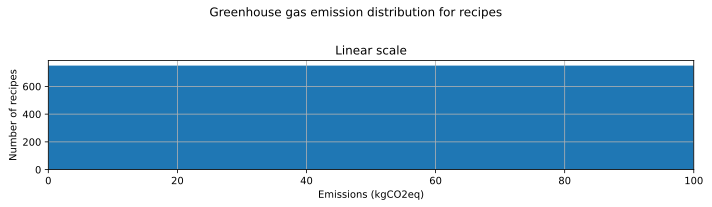

In [12]:
f, (ax1)= plt.subplots(1, 1, sharey=True, figsize=(10,3))

ax1.hist(df['GHG_Emission'].dropna(), bins=300)
ax1.set_xlim([0, 100])
ax1.set_xlabel('Emissions (kgCO2eq)')
ax1.set_ylabel('Number of recipes')
ax1.set_title('Linear scale')
ax1.grid()

f.suptitle('Greenhouse gas emission distribution for recipes')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

In [13]:
print(' ')
print('Sustainable:')
print(df.loc[(df["Group"] == 0), ["Recipe","Perc_Sustainability"]])
print(' ')
print('Not sustainable:')
print(df.loc[(df["Group"] == 1), ["Recipe","Perc_Sustainability"]])
print(' ')
print('Absolutely not sustainable:')
print(df.loc[(df["Group"] == 2), ["Recipe","Perc_Sustainability"]])

 
Sustainable:
                                                 Recipe  Perc_Sustainability
5       Chicken and Leek Pasties Recipe | Cook the Book                   85
20    Roman-Jewish Fried Artichokes (Carciofi alla G...                   94
34                           Homemade Tater Tots Recipe                   98
41          Crispy Vegan Smoked-Mushroom "Bacon" Recipe                   84
43      Taiwanese Three Cup Chicken (San Bei Ji) Recipe                   88
...                                                 ...                  ...
1465                               Curry Ketchup Recipe                   82
1466                  Long Loaves Recipe | Bread Baking                   79
1468                  Marinated Artichoke Hearts Recipe                   84
1470                    Pickled Oyster Mushrooms Recipe                   88
1471                 Sweet Pickled Daikon Radish Recipe                   93

[334 rows x 2 columns]
 
Not sustainable:
                  

In [14]:
df[['Group']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Group,1472.0,1.451766,0.837827,0.0,1.0,2.0,2.0,2.0


In [15]:
reviews = pd.read_csv('Review.csv')
reviews['RecipeId'] = np.random.randint(1, len(df), reviews.shape[0])
reviews = reviews.astype(object)
reviews.head()

,Id,UserId,ProfileName,Score,Time,RecipeId
0,1,A3SGXH7AUHU8GW,delmartian,5,1303862400,190
1,2,A1D87F6ZCVE5NK,dll pa,1,1346976000,261
2,3,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,593
3,4,A395BORC6FGVXV,Karl,2,1307923200,148
4,5,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,1326


In [16]:
reviews.shape

(568454, 6)

In [17]:
print('Number of unique Users in Raw data = ', reviews['UserId'].nunique())
print('Number of unique Recipes in Raw data = ', reviews['RecipeId'].nunique())

Number of unique Users in Raw data =  256059
Number of unique Recipes in Raw data =  1471


In [18]:
def data_clean(dfs, feature, m):
    count = dfs[feature].value_counts()
    dfs = dfs[dfs[feature].isin(count[count > m].index)]
    return dfs

def data_clean_sum(dfs,features,m):
    fil = dfs.RecipeId.value_counts()
    fil2 = dfs.UserId.value_counts()
    dfs['#RecipeId'] = dfs.RecipeId.apply(lambda x: fil[x])
    dfs['#UserId'] = dfs.UserId.apply(lambda x: fil2[x])    
    while (dfs.RecipeId.value_counts(ascending=True)[1]) < m or (dfs.UserId.value_counts(ascending=True)[0] < m):
        dfs = data_clean(dfs,features[0],m)
        dfs = data_clean(dfs,features[1],m)
    return dfs

In [19]:
def data(reviews):
    print('loading data...')
    dfs = reviews
    dfs['datetime'] = pd.to_datetime(dfs.Time, unit='s')
    raw_data = data_clean_sum(dfs, ['RecipeId', 'UserId'], 10)
    raw_data['usrid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['recpid'] = pd.factorize(raw_data['RecipeId'])[0]
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#UserId'].values.reshape(-1,1))
    raw_data['nrecipe']=sc.fit_transform(raw_data['#RecipeId'].values.reshape(-1,1))
    
    X1 = raw_data.loc[:,['usrid','recpid']]
    X2 = raw_data.loc[:,['usrid','recpid','time']]
    X3 = raw_data.loc[:,['usrid','recpid','time','nuser','nrecipe']]
    y = raw_data.Score
    
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    
    rec2PID = raw_data.RecipeId.unique()
    data_mixed = X1.join(y)
    total_r = data_mixed['recpid'].unique().shape[0]
    total_u = data_mixed['usrid'].unique().shape[0]
    
    table = np.zeros([total_u,total_r])
    z = np.array(data_mixed)
    for line in z:
        u,r,s = line
        if table[u][r] < s:
            table[u][r] = s 
    print('the table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_r,rec2PID,train,test,table,raw_data

z, total_u,total_r,rec2PID,train,test,table,raw_data = data(reviews)

loading data...
the table's shape is:
(6359, 1471)


In [20]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def calculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0

In [21]:
def stack_table(get_ranks):
    rnk1dit = {"RecipeId": [], "Recipes": [], "Perc_Sustainability": []}
    rnk2dit = {"RecipeId": [], "Recipes": [], "Perc_Sustainability": []}
    rnk3dit = {"RecipeId": [], "Recipes": [], "Perc_Sustainability": []}

    for i in range(len(get_ranks)):
        rnk = df.loc[get_ranks[i], ['RecipeId', 'Recipe', 'Group', 'Perc_Sustainability']]
        if rnk['Group'] == 0:
            rnk1dit["RecipeId"].append(rnk['RecipeId'])
            rnk1dit["Recipes"].append(rnk['Recipe'])
            rnk1dit["Perc_Sustainability"].append(rnk['Perc_Sustainability'])        
        elif rnk['Group'] == 1:
            rnk2dit["RecipeId"].append(rnk['RecipeId'])
            rnk2dit["Recipes"].append(rnk['Recipe'])
            rnk2dit["Perc_Sustainability"].append(rnk['Perc_Sustainability'])  
        else:
            rnk3dit["RecipeId"].append(rnk['RecipeId'])
            rnk3dit["Recipes"].append(rnk['Recipe'])
            rnk3dit["Perc_Sustainability"].append(rnk['Perc_Sustainability'])  

    return rnk1dit, rnk2dit, rnk3dit

In [22]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, labels=['not','recommand'], normalize=True)
    plt.show()

# Random Forest Regressor

train MSE is (0.10313907836199669, 0.7545197483629589), test MSE is 0.7545197483629589
accuracy of recommandation:
0.7876783130039281
accuracy of not recommandation:
0.9418802977051892
Normalized confusion matrix
[[0.73 0.27]
 [0.19 0.81]]


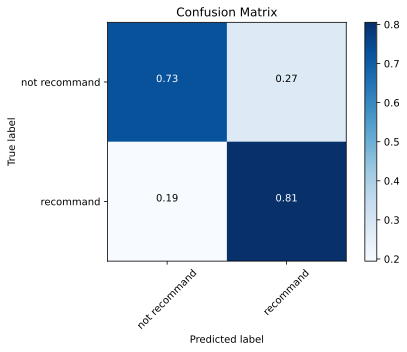

RandomForestRegressor()

In [23]:
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.metrics import accuracy_score


def rf():
    raw_data['usrid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['recpid'] = pd.factorize(raw_data['RecipeId'])[0]
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#UserId'].values.reshape(-1,1))
    raw_data['nrecipe']=sc.fit_transform(raw_data['#RecipeId'].values.reshape(-1,1))
    
    
    X1 = raw_data.loc[:,['usrid','recpid']]
    X2 = raw_data.loc[:,['usrid','recpid','time']]
    X3 = raw_data.loc[:,['usrid','recpid','time','nuser','nrecipe']]
    y = raw_data.Score

    from sklearn.model_selection import train_test_split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    
    a=RandomForestRegressor()
    a.fit(X3_train,y_train)
    y3 = a.predict(X3_test)
    sc = MinMaxScaler(feature_range=(1,5))
    c = mean_squared_error(y_train,a.predict(X3_train)), mean_squared_error(y_test,sc.fit_transform(y3.reshape(-1,1)))
    b = mean_squared_error(y_test,y3)
    print('train MSE is {}, test MSE is {}'.format(c,b))

    c3 = y3>=4
    t = y_test>=4
    print('accuracy of recommandation:')
    print(accuracy_score(t,c3))
    c31 = y3<=1
    t1 = y_test<=1
    print('accuracy of not recommandation:')
    print(accuracy_score(t1,c31))
    y_pred3 = []
    y_test3 = []
    for i in range(y3.shape[0]):
        if y3[i]>=4:
            y_pred3.append(1)
        elif y3[i]<4:
            y_pred3.append(0)
        # else:
            # y_pred3.append(1)

    for j in range(y3.shape[0]):
        if np.array(y_test)[j]>=4:
            y_test3.append(1)
        elif np.array(y_test)[j]<4:
            y_test3.append(0)
        # else:
            # y_test3.append(1)
            
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(y_test3,y_pred3)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, labels=class_names, normalize=True)
    plt.show()
    return a
rf()

In [24]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

RandomForestRegressor(n_estimators=10, n_jobs=1)

In [25]:
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top {} recommanded Recipes for User ID {} is {}'.format(n,uid,top_N))
        if rawId == True:
            print('the real ID is {}'.format(rec2PID[top_N]))
    else:
        print('this user has not reviewed anything, plz use other methods')
    return top_N

the in sample MSE = 1.9785051540581002 
the out sample MSE = 1.945813594165255
caculating cm..
Normalized confusion matrix
[[0.16 0.84]
 [0.19 0.81]]


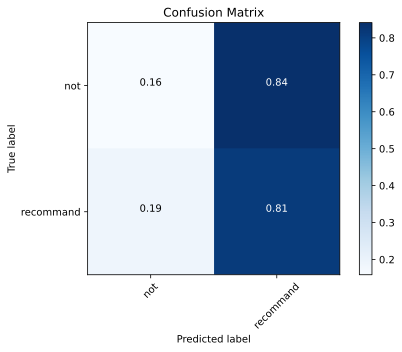

the top 10 recommanded Recipes for User ID 10 is [ 844 1258  795   10 1370 1227 1449   11 1195 1144]
the real ID is [431 894 27 1013 1434 157 1066 1264 267 1250]
Sustainable
   RecipeId                                        Recipes  \
0      1639  Sichuan-Style Asparagus and Tofu Salad Recipe   

   Perc_Sustainability  
0                   78  

Not Sustainable
   RecipeId                                            Recipes  \
0      1141              Halloumi and Vegetable Skewers Recipe   
1      1694  7 Things To Do with Garlic Scapes Recipe | The...   
2      1565                  Hainanese Chicken Rice Set Recipe   

   Perc_Sustainability  
0                   71  
1                   72  
2                   71  

Absolutely Not Sustainable
   RecipeId                                            Recipes  \
0      1746                                   Chess Pie Recipe   
1      1074  Creamy White Beans With 'Nduja, Kale, and Grem...   
2        16    Pumpkin Cheesecake With Ging

In [26]:
from sklearn.metrics.pairwise import pairwise_distances

def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a

result =cf()
calculate_mse(result)
drawcm(result,title='MF')
get_ranks = rec(result, 10,10,rawId= True)

rnk1dit, rnk2dit, rnk3dit = stack_table(get_ranks)

print('Sustainable')
print(pd.DataFrame(rnk1dit))
print()

print('Not Sustainable')
print(pd.DataFrame(rnk2dit))
print()

print('Absolutely Not Sustainable')
print(pd.DataFrame(rnk3dit))


the in sample MSE = 4.311496335560282 
the out sample MSE = 4.31475546599779
caculating cm..
Normalized confusion matrix
[[0.99 0.01]
 [0.92 0.08]]


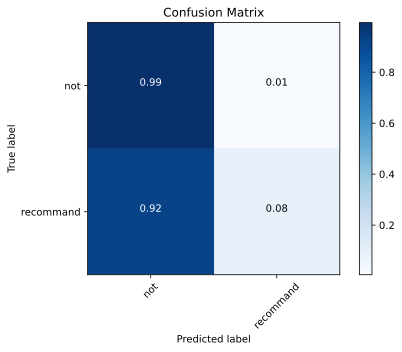

the top 10 recommanded Recipes for User ID 10 is [1195   10  238 1275  513  251 1370  138  888 1341]
the real ID is [267 1013 533 1029 1354 965 1434 662 1276 1379]
Sustainable
   RecipeId                                            Recipes  \
0      1639      Sichuan-Style Asparagus and Tofu Salad Recipe   
1      1193  Arroz Aguado (Nicaraguan Chicken and Rice Stew...   

   Perc_Sustainability  
0                   78  
1                   86  

Not Sustainable
   RecipeId                                            Recipes  \
0       280                    Homemade Pistachio Paste Recipe   
1       660  Warm Farro Salad With Asparagus, Peas, and Fet...   

   Perc_Sustainability  
0                   70  
1                   68  

Absolutely Not Sustainable
   RecipeId                                            Recipes  \
0        16    Pumpkin Cheesecake With Gingersnap Crust Recipe   
1      1771                           Bourbon Peach Jam Recipe   
2       295  Tender Braised Lamb 

In [27]:
from numpy import *
from scipy.sparse.linalg import svds
from numpy import linalg as la
from sklearn.preprocessing import MinMaxScaler

def svdrec(table = table, factors= 150):
    UI = matrix(table)
    user_ratings_mean=mean(UI,axis=0)
    user_ratings_mean=user_ratings_mean.reshape(1,-1)
    UI_demeaned=UI-user_ratings_mean
    U,sigma,Vt=svds(UI_demeaned,factors)
    sigma=diag(sigma)
    pred_mat=dot(dot(U,sigma),Vt) + user_ratings_mean
    sc=MinMaxScaler(feature_range = (1,5))
    pred_mat = sc.fit_transform(pred_mat)
    return pred_mat

def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top {} recommanded Recipes for User ID {} is {}'.format(n,uid,top_N))
        if rawId == True:
            print('the real ID is {}'.format(rec2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N

result1 =svdrec(factors=150)
calculate_mse(result1)
drawcm(result1,title='SVD')
get_ranks = rec(result1, 10,10,rawId= True)
rnk1dit, rnk2dit, rnk3dit = stack_table(get_ranks)

print('Sustainable')
print(pd.DataFrame(rnk1dit))
print()

print('Not Sustainable')
print(pd.DataFrame(rnk2dit))
print()

print('Absolutely Not Sustainable')
print(pd.DataFrame(rnk3dit))


iter = 1, loss = 7227.855172716568, delta_loss = -7227.855172716568, LR = 0.02
iter = 2, loss = 2069.7032152782544, delta_loss = 5158.151957438313, LR = 0.01
iter = 3, loss = 2009.110530359421, delta_loss = 60.592684918833356, LR = 0.0105
iter = 4, loss = 1979.8224343059667, delta_loss = 29.28809605345441, LR = 0.011025000000000002
iter = 5, loss = 1947.9042533497582, delta_loss = 31.918180956208516, LR = 0.011576250000000003
iter = 6, loss = 1907.5201912514945, delta_loss = 40.38406209826371, LR = 0.012155062500000004
iter = 7, loss = 1855.008105504634, delta_loss = 52.51208574686052, LR = 0.012762815625000005
iter = 8, loss = 1786.8126437391581, delta_loss = 68.19546176547578, LR = 0.013400956406250006
iter = 9, loss = 1699.8505296429382, delta_loss = 86.96211409621992, LR = 0.014071004226562506
iter = 10, loss = 1592.6261540463431, delta_loss = 107.22437559659511, LR = 0.014774554437890632
iter = 11, loss = 1466.5184825746094, delta_loss = 126.10767147173374, LR = 0.0155132821597851

iter = 87, loss = 48.090117101762594, delta_loss = 0.5086611190495063, LR = 0.0035120068783193446
iter = 88, loss = 47.95867243292207, delta_loss = 0.13144466884052264, LR = 0.003687607222235312
iter = 89, loss = 47.87717089762812, delta_loss = 0.08150153529395254, LR = 0.003871987583347078
iter = 90, loss = 47.822373425967015, delta_loss = 0.054797471661103714, LR = 0.004065586962514432
iter = 91, loss = 47.78691584011011, delta_loss = 0.035457585856903506, LR = 0.004268866310640154
iter = 92, loss = 47.76750116200983, delta_loss = 0.019414678100282856, LR = 0.004482309626172162
iter = 93, loss = 47.76248065340036, delta_loss = 0.005020508609469232, LR = 0.00470642510748077
iter = 94, loss = 47.77105255652314, delta_loss = -0.008571903122778224, LR = 0.004941746362854809
iter = 95, loss = 46.395471870855815, delta_loss = 1.3755806856673232, LR = 0.0024708731814274045
iter = 96, loss = 46.04006516383669, delta_loss = 0.355406707019128, LR = 0.0025944168404987747
iter = 97, loss = 45.96

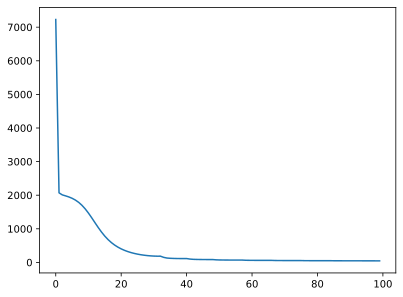

the in sample MSE = 0.01706644553740622 
the out sample MSE = 0.017543551547220662
caculating cm..
Normalized confusion matrix
[[1.   0.  ]
 [0.12 0.88]]


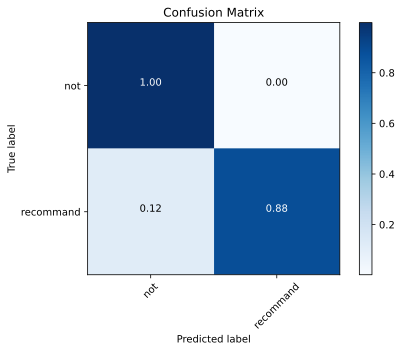

the top10 recommanded products for User ID 10 is [ 346  656 1383  682 1125  600  398  959  424 1347]
the real ID is [1391 1078 305 812 570 1083 1117 39 219 1301]
Sustainable
   RecipeId                                        Recipes  \
0      1940         Fodni Bhaat (Indian Fried Rice) Recipe   
1      1543                      Za'atar Rice Pilaf Recipe   
2       775  Slow-Roasted Spice-Rubbed Venison Loin Recipe   
3      1292          Browned Butter Pecan Ice Cream Recipe   

   Perc_Sustainability  
0                   86  
1                   90  
2                   89  
3                   87  

Not Sustainable
   RecipeId                                            Recipes  \
0       533  Warm Spanish-Style Giant-Bean Salad With Smoke...   

   Perc_Sustainability  
0                   69  

Absolutely Not Sustainable
   RecipeId                                            Recipes  \
0       418                            Whipped Feta Dip Recipe   
1       853  Trevisano Radicch

In [28]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_r, factors) / 3
    y = []
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2 / 50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

result =MF1( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
calculate_mse(result)
drawcm(result,title='MF')

def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for User ID {} is {}'.format(n,uid,top_N))
        if rawId == True:
            print('the real ID is {}'.format(rec2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
get_ranks = rec(result, 10,10,rawId= True)
rnk1dit, rnk2dit, rnk3dit = stack_table(get_ranks)

print('Sustainable')
print(pd.DataFrame(rnk1dit))
print()

print('Not Sustainable')
print(pd.DataFrame(rnk2dit))
print()

print('Absolutely Not Sustainable')
print(pd.DataFrame(rnk3dit))

iter = 1, loss = 7523.8400278629315, delta_loss = -7423.8400278629315, LR = 0.02
iter = 2, loss = 2357.415045004129, delta_loss = 5166.424982858803, LR = 0.01
iter = 3, loss = 2297.6449592974545, delta_loss = 59.77008570667431, LR = 0.0105
iter = 4, loss = 2270.9003746709914, delta_loss = 26.744584626463165, LR = 0.011025000000000002
iter = 5, loss = 2243.2859851708004, delta_loss = 27.61438950019101, LR = 0.011576250000000003
iter = 6, loss = 2209.2991231322944, delta_loss = 33.98686203850593, LR = 0.012155062500000004
iter = 7, loss = 2165.771647586998, delta_loss = 43.52747554529651, LR = 0.012762815625000005
iter = 8, loss = 2109.599963511871, delta_loss = 56.171684075126905, LR = 0.013400956406250006
iter = 9, loss = 2037.8282292401157, delta_loss = 71.77173427175535, LR = 0.014071004226562506
iter = 10, loss = 1948.4333979677428, delta_loss = 89.39483127237281, LR = 0.014774554437890632
iter = 11, loss = 1841.4767323024764, delta_loss = 106.95666566526643, LR = 0.0155132821597851

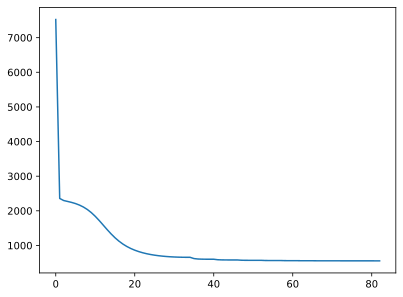

the in sample MSE = 0.025324723816324026 
the out sample MSE = 0.02609930471847824
caculating cm..
Normalized confusion matrix
[[1.   0.  ]
 [0.13 0.87]]


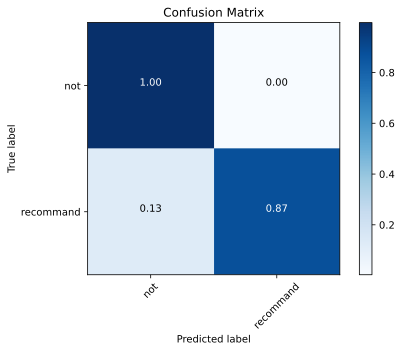

the top200 recommanded products for User ID 10 is [  70  531  394  253  587 1070  826  327   60 1232  625  931  979   50
  365  154  551  280  102   35  854  196   20  514 1457 1029 1297  802
  440 1300  123  668  892  812  794  432  136 1199 1064 1310  905  791
  543  450  641  423  202  106 1451  183 1186 1060  216  917 1446 1217
 1172  455  777   11  502 1284  924  222  928  632   87  140  500   84
  682 1142  932 1344 1157  765 1347  227  935  406  938  939 1023  403
 1220  822  750 1358  943  245  881 1275 1073 1054 1224 1366  743 1052
 1226  338 1037 1372  737  146  266 1376  966  385  727 1436  472  970
  381 1384 1117  973  649  602  377 1113  981  375  608  334 1041 1396
 1397  857 1015 1012  155  611  714  286 1433  994  290  292  486 1098
  617  707  842  618 1096   33  355  702  363 1420  620 1422  621  999
 1003 1004  297  695  693 1008  331  995   46 1400  610 1380 1370  252
  163  944  569  758 1341 1161  919 1173   10 1448 1449  343  203  424
 1195  427  122  192  805 1

In [29]:
def PMF(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_r, factors) / 3
    y = []
    iteration = 0
    last_loss = 100
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[u], Q[p])
            loss += error ** 2/50
            pp = P[u]
            qq = Q[p]
            P[u] += LRate *  (error * qq - regU*pp)
            Q[p] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

result =PMF( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
calculate_mse(result)
drawcm(result,title='PMF')

def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for User ID {} is {}'.format(n,uid,top_N))
        if rawId == True:
            print('the real ID is {}'.format(rec2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N

get_ranks = rec(result, 10,200,rawId= True)
rnk1dit, rnk2dit, rnk3dit = stack_table(get_ranks)

print('Sustainable')
print(pd.DataFrame(rnk1dit)[:9])
print()

print('Not Sustainable')
print(pd.DataFrame(rnk2dit))
print()

print('Absolutely Not Sustainable')
print(pd.DataFrame(rnk3dit))